# Tutorial 3: K-Means and Time Domain Reduction

A good tool to reduce computation time of GenX is to use <a href="https://genxproject.github.io/GenX/dev/methods/#Time-Domain-Reduction-(TDR)" target="_blank">Time Domain Reduction (TDR)</a>. Time Domain Reduction is a method that selects a smaller set of time steps from the data in a way that reduces computation time while still capturing the main information of the model. In this tutorial, we go over how TDR works in GenX and how it uses K-means clustering to choose the optimal time steps.

### Time Domain Reduction

To see how Time Domain Reduction works, let's look at the `Load_data` in `Example_Systems_Tutorials/SmallNewEngland/OneZone/`:

In [301]:
# First, load all packages needed
using DataFrames
using CSV
using VegaLite
using YAML
using TickTock
using PlotlyJS
using Plots
using Clustering
using ScikitLearn
@sk_import datasets: (make_blobs)

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
   Installed TickTock ─ v1.3.0
    Updating `~/Desktop/GenX/Project.toml`
  [9ff05d80] + TickTock v1.3.0
    Updating `~/Desktop/GenX/Manifest.toml`
  [9ff05d80] + TickTock v1.3.0
Precompiling project...
  ✓ TickTock
  ✓ GenX
  2 dependencies successfully precompiled in 7 seconds. 128 already precompiled.
  1 dependency precompiled but a different version is currently loaded. Restart julia to access the new version


In [259]:
loads = CSV.read("Example_Systems_Tutorials/SmallNewEngland/OneZone/Load_data.csv",DataFrame,missingstring="NA")

8760×9 DataFrame
  Row │ Voll     Demand_Segment  Cost_of_Demand_Curtailment_per_MW  Max_Demand ⋯
      │ String7  String3         String3                            String3    ⋯
──────┼─────────────────────────────────────────────────────────────────────────
    1 │ 50000    1               1                                  1          ⋯
    2 │
    3 │
    4 │
    5 │                                                                        ⋯
    6 │
    7 │
    8 │
    9 │                                                                        ⋯
   10 │
   11 │
  ⋮   │    ⋮           ⋮                         ⋮                             ⋱
 8751 │
 8752 │                                                                        ⋯
 8753 │
 8754 │
 8755 │
 8756 │                                                                        ⋯
 8757 │
 8758 │
 8759 │
 8760 │                                                                        ⋯
                                                 6 columns and 8739 rows omitted

The most columns to note in this file are `Rep_Periods`, `TimeSteps_Per_Rep_Period`, `Time_Index`, and `Load_MW_z1`. This file shows the number of time steps used in GenX before applying TDR, i.e. every hour in a year, totaling 8,760 hours. This means that there is only one representative period, as seen in `Rep_Periods`.

Below shows the load per timestep in megawatts:

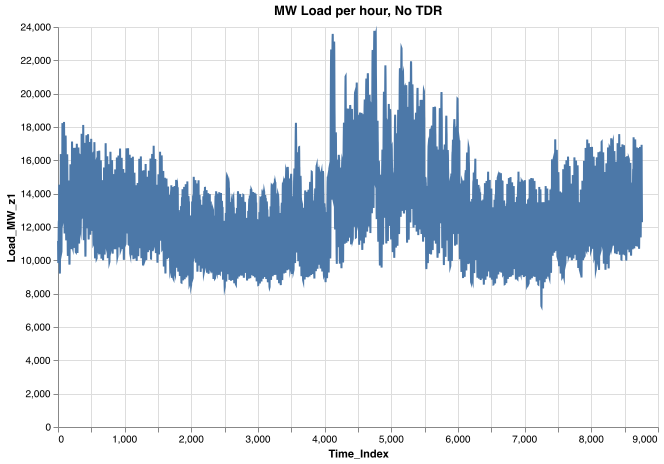

In [260]:
loads |>
@vlplot(:line, 
    x=:Time_Index, y=:Load_MW_z1, title="MW Load per hour, No TDR",
    width=600,height=400,linewidth=.01)

As in Tutorial 1, we can open the `genx_settings.yml` file for `SmallNewEngland/OneZone` to see how `TimeDomainReduction` is set. If it's set to 1, this means TDR is being used.

In [303]:
genx_settings_SNE = YAML.load(open("Example_Systems_Tutorials/SmallNewEngland/OneZone/Settings/genx_settings.yml"))

Dict{Any, Any} with 21 entries:
  "NetworkExpansion"                        => 0
  "TimeDomainReductionFolder"               => "TDR_Results"
  "ModelingToGenerateAlternativeIterations" => 3
  "ParameterScale"                          => 1
  "EnergyShareRequirement"                  => 1
  "PrintModel"                              => 0
  "TimeDomainReduction"                     => 1
  "Trans_Loss_Segments"                     => 1
  "CapacityReserveMargin"                   => 1
  "ModelingtoGenerateAlternativeSlack"      => 0.1
  "Solver"                                  => "HiGHS"
  "MethodofMorris"                          => 0
  "Reserves"                                => 0
  "StorageLosses"                           => 1
  "OverwriteResults"                        => 0
  "UCommit"                                 => 2
  "ModelingToGenerateAlternatives"          => 0
  "MaxCapReq"                               => 1
  "MinCapReq"                               => 1
  "CO2Cap"       

To visualize how TDR decreases computation time, let's start by running `SmallNewEngland/OneZone` without TDR. We'll use the package `TickTock` to track the runtime.

To run GenX without TDR, we start by editing the settings to set `TimeDomainReduction` to 0:

In [304]:
genx_settings_SNE["TimeDomainReduction"] = 0
genx_settings_SNE ## Output settings

Dict{Any, Any} with 21 entries:
  "NetworkExpansion"                        => 0
  "TimeDomainReductionFolder"               => "TDR_Results"
  "ModelingToGenerateAlternativeIterations" => 3
  "ParameterScale"                          => 1
  "EnergyShareRequirement"                  => 1
  "PrintModel"                              => 0
  "TimeDomainReduction"                     => 0
  "Trans_Loss_Segments"                     => 1
  "CapacityReserveMargin"                   => 1
  "ModelingtoGenerateAlternativeSlack"      => 0.1
  "Solver"                                  => "HiGHS"
  "MethodofMorris"                          => 0
  "Reserves"                                => 0
  "StorageLosses"                           => 1
  "OverwriteResults"                        => 0
  "UCommit"                                 => 2
  "ModelingToGenerateAlternatives"          => 0
  "MaxCapReq"                               => 1
  "MinCapReq"                               => 1
  "CO2Cap"       

Then we write the edited settings to the file path:

In [305]:
YAML.write_file("Example_Systems_Tutorials/SmallNewEngland/OneZone/Settings/genx_settings.yml", genx_settings_SNE)

And run it using `include`. (Note: this process will take a few minutes):

In [306]:
tick()
include("Example_Systems_Tutorials/SmallNewEngland/OneZone/Run.jl")
tock()

Configuring Settings
Configuring Solver
Loading Inputs
Reading Input CSV Files
Network.csv Successfully Read!
Load_data.csv Successfully Read!
Fuels_data.csv Successfully Read!
Generators_data.csv Successfully Read!
Generators_variability.csv Successfully Read!
Validating time basis
Capacity_reserve_margin.csv Successfully Read!
Minimum_capacity_requirement.csv Successfully Read!
Maximum_capacity_requirement.csv Successfully Read!
Energy_share_requirement.csv Successfully Read!
CO2_cap.csv Successfully Read!
CSV Files Successfully Read In From /Users/mayamutic/Desktop/GenX/Example_Systems/SmallNewEngland/OneZone
Generating the Optimization Model
Discharge Module


[ Info:  started timer at: 2024-01-14T18:50:47.180


Non-served Energy Module
Investment Discharge Module
Unit Commitment Module
Emissions Module (for CO2 Policy modularization
Dispatchable Resources Module
Storage Resources Module
Storage Investment Module
Storage Core Resources Module
Storage Resources with Symmetric Charge/Discharge Capacity Module
Thermal (Unit Commitment) Resources Module
C02 Policies Module
Energy Share Requirement Policies Module
Capacity Reserve Margin Policies Module
Minimum Capacity Requirement Module
Maximum Capacity Requirement Module
Time elapsed for model building is
0.555159583
Solving Model
Running HiGHS 1.6.0: Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
170620 rows, 83017 cols, 646999 nonzeros
161830 rows, 74231 cols, 653419 nonzeros
Presolve : Reductions: rows 161830(-30906); columns 74231(-13381); elements 653419(-134175)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0    -4.2035774355e+00 Ph1: 2

[ Info:        153.662797875s: 2 minutes, 33 seconds, 662 milliseconds


This took a little while to run, and would take even longer for larger systems. Let's see how we can get the run time down using Time Domain Reduction. The next sections go over how K-means clustering is used to perform TDR, and how to interpret the resulting files in GenX.

### K-means clustering

Let's go over how TDR works. To perform TDR, GenX uses K-means clustering. K-means is an optimization method that clusters data into several groups based on their proximity to "centers" determined by the algorithm. Clustering data is 

To be more specific, k-means finds a set number of groups such that the variance between the distance of each point in the group to the mean of the group is minimized. 

$$
\begin{align*}
\mathop{\arg \min}\limits_{\mathbf{S}} & \sum_{i = 1}^k \sum_{x \in S_i} ||x - \mu_i||^2 \\
\end{align*}
$$

Where $\mathbf{S} = \{S_1, ... , S_k\}$ are the clusters, and $\mu_i$ is the mean of each cluster i.e. the mean of the distances between each point in the cluster. By taking the argmin over $\mathbf{S}$, the points $x$ are clustered into groups where their distance to the center is the smallest.

GenX uses the package `Clustering.jl`, with documentation <a href="https://juliastats.org/Clustering.jl/dev/kmeans.html#K-means" target="_blank">here</a>. As an example, using the package `ScikitLearn.jl`, let's generate data that can cluster easily.

In [457]:
X, y = make_blobs(n_samples=100,centers=5,random_state=8);
b = DataFrame(X,:auto)

100×2 DataFrame
 Row │ x1         x2        
     │ Float64    Float64   
─────┼──────────────────────
   1 │ -1.72161   -1.48033
   2 │ -7.74065   -8.61801
   3 │  1.27318    0.914331
   4 │ -0.778866  -1.29531
   5 │  7.48006    2.49393
   6 │  8.91111    9.14933
   7 │ -2.27579   -2.897
   8 │ -2.91716   -0.816103
   9 │  1.78493   -1.25974
  10 │  7.71891    0.991913
  11 │  6.28516   11.2872
  ⋮  │     ⋮          ⋮
  91 │ -1.90119   -2.12454
  92 │  0.587433  -0.813353
  93 │  6.57243   -1.02614
  94 │  7.63027    8.69798
  95 │ -1.45137   -4.38746
  96 │ -7.18598   -9.36698
  97 │ -2.60104   -1.52873
  98 │  7.81296   -0.534152
  99 │  7.53582    0.617749
 100 │ -0.203394   1.08106
             79 rows omitted

Note that clustering works for data without obvious groupings, but using blobs as an example makes k-means easier to visualize.

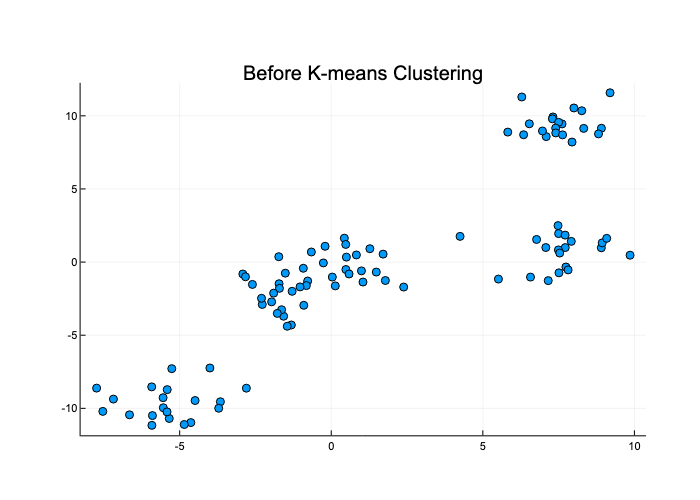

In [458]:
plotlyjs()
Plots.scatter(b[!,"x1"],b[!,"x2"],legend=false,title="Before K-means Clustering")

Now we use the function `kmeans`, which is also used in `src/time_domain_reduction` in GenX.

In [460]:
R = kmeans(transpose(Matrix(b)),5)

KmeansResult{Matrix{Float64}, Float64, Int64}([-0.5983234957845184 7.533257370256171 … 7.527880189472178 -5.971220015686362; -1.2278405241483499 9.450101620955774 … 0.6882845988483258 -9.984381244149827], [1, 5, 1, 1, 4, 2, 1, 1, 1, 4  …  1, 1, 4, 2, 1, 5, 1, 4, 4, 1], [1.3255250419151228, 4.997847745986178, 8.091409099122394, 0.03714790494307074, 3.2626391548434412, 1.9889458740610166, 5.599991619086529, 5.546511424821204, 5.6808996899043525, 0.1286842679680973  …  2.501523413471922, 1.5778169684187557, 3.852127483939782, 0.5750996178271066, 10.710858491505114, 1.8568275420579425, 4.101412120977988, 1.5756217190165671, 0.005038328827794203, 5.487009130161922], [40, 20, 6, 20, 14], [40, 20, 6, 20, 14], 284.066131030526, 4, true)

`kmeans` returns three outputs: assignments, centers, and counts. Assignments shows to which cluster each points belongs, centers shows where the center coordinates of each cluster are, and counts shows how many points belong to each cluster.

In [470]:
println(R.assignments)

[1, 5, 1, 1, 4, 2, 1, 1, 1, 4, 2, 2, 4, 1, 4, 1, 3, 4, 4, 1, 2, 2, 1, 5, 4, 2, 2, 1, 2, 4, 3, 1, 5, 5, 1, 1, 4, 1, 1, 2, 5, 1, 5, 3, 5, 1, 2, 1, 5, 2, 5, 4, 4, 1, 2, 2, 1, 1, 5, 3, 2, 1, 1, 5, 4, 1, 2, 4, 1, 5, 2, 2, 4, 1, 4, 3, 2, 4, 1, 1, 1, 5, 1, 2, 1, 1, 1, 1, 4, 3, 1, 1, 4, 2, 1, 5, 1, 4, 4, 1]


In [463]:
R.centers

2×5 Matrix{Float64}:
 -0.598323  7.53326  -3.98791  7.52788   -5.97122
 -1.22784   9.4501   -8.69267  0.688285  -9.98438

In [471]:
R.counts

5-element Vector{Int64}:
 40
 20
  6
 20
 14

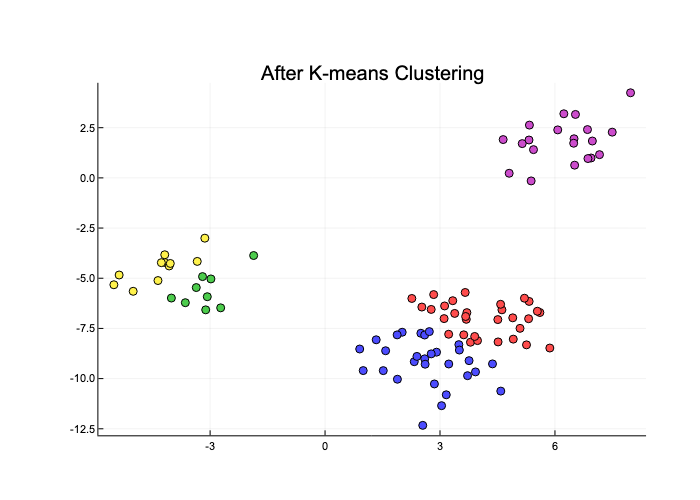

In [453]:
plotlyjs()
Plots.scatter(b[!,"x1"],b[!,"x2"],legend=false,marker_z=R.assignments,c=:lightrainbow,title="After K-means Clustering")

In [ ]:
# Ask F: how are representative sets selected?

### Results of Time Domain Reduction

To visualize the results of TDR, we'll set TDR = 1 back in the `genx_settings.yml` file in `Example_Systems_Tutorials/SmallNewEngland/OneZone/`:

In [295]:
genx_settings_SNE["TimeDomainReduction"] = 1;

In [296]:
genx_settings_SNE

Dict{Any, Any} with 21 entries:
  "NetworkExpansion"                        => 0
  "TimeDomainReductionFolder"               => "TDR_Results"
  "ModelingToGenerateAlternativeIterations" => 3
  "ParameterScale"                          => 1
  "EnergyShareRequirement"                  => 1
  "PrintModel"                              => 0
  "TimeDomainReduction"                     => 1
  "Trans_Loss_Segments"                     => 1
  "CapacityReserveMargin"                   => 1
  "ModelingtoGenerateAlternativeSlack"      => 0.1
  "Solver"                                  => "HiGHS"
  "MethodofMorris"                          => 0
  "Reserves"                                => 0
  "StorageLosses"                           => 1
  "OverwriteResults"                        => 0
  "UCommit"                                 => 2
  "ModelingToGenerateAlternatives"          => 0
  "MaxCapReq"                               => 1
  "MinCapReq"                               => 1
  "CO2Cap"       

In [475]:
YAML.write_file("Example_Systems_Tutorials/SmallNewEngland/OneZone/Settings/genx_settings.yml", genx_settings_SNE)

And run GenX again with TDR:

In [473]:
tick()
include("Example_Systems_Tutorials/SmallNewEngland/OneZone/Run.jl")
tock()

[ Info:  started timer at: 2024-01-15T19:59:06.005


Configuring Settings
Configuring Solver
Loading Inputs
Reading Input CSV Files
Network.csv Successfully Read!
Load_data.csv Successfully Read!
Fuels_data.csv Successfully Read!
Generators_data.csv Successfully Read!
Generators_variability.csv Successfully Read!
Validating time basis
CSV Files Successfully Read In From /Users/mayamutic/Desktop/GenX/Tutorials/Example_Systems_Tutorials/SmallNewEngland/OneZone
Generating the Optimization Model
Discharge Module
Non-served Energy Module
Investment Discharge Module
Emissions Module (for CO2 Policy modularization
Dispatchable Resources Module
Storage Resources Module
Storage Investment Module
Storage Core Resources Module
Storage Resources with Symmetric Charge/Discharge Capacity Module
Thermal (No Unit Commitment) Resources Module
Time elapsed for model building is
1.478717916
Solving Model
Running HiGHS 1.6.0: Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
109294 rows, 56737 cols, 292840 nonzeros
104401 rows, 51844 cols, 2

[ Info:         16.213814459s: 16 seconds, 213 milliseconds


Csv files with the results of TDR are generated automatically in a folder called `TDR_results` found within the same folder containing the input csv files, in this case `Example_Systems/SmallNewEngland/OneZone`. The csv files in this folder show the files used in `Run.jl` that have been pared down from the initial input files.

As an example, consider the input file `Fuels_data.csv`:

In [472]:
Fuels_original = CSV.read("Example_Systems_Tutorials/SmallNewEngland/OneZone/Fuels_data.csv",DataFrame,missingstring="NA")


8761×3 DataFrame
  Row │ Time_Index  NG       None  
      │ Int64       Float64  Int64 
──────┼────────────────────────────
    1 │          0  0.05306      0
    2 │          1  5.28         0
    3 │          2  5.28         0
    4 │          3  5.28         0
    5 │          4  5.28         0
    6 │          5  5.28         0
    7 │          6  5.28         0
    8 │          7  5.28         0
    9 │          8  5.28         0
   10 │          9  5.28         0
   11 │         10  5.28         0
  ⋮   │     ⋮          ⋮       ⋮
 8752 │       8751  4.28         0
 8753 │       8752  4.28         0
 8754 │       8753  4.28         0
 8755 │       8754  4.28         0
 8756 │       8755  4.28         0
 8757 │       8756  4.28         0
 8758 │       8757  4.28         0
 8759 │       8758  4.28         0
 8760 │       8759  4.28         0
 8761 │       8760  4.28         0
                  8740 rows omitted

Compared to `TDR_Results/Fuels_data.csv`:

In [7]:
Fuels_TDR = CSV.read("../Example_Systems/SmallNewEngland/OneZone/TDR_Results/Fuels_data.csv",DataFrame,missingstring="NA")

1849×3 DataFrame
  Row │ Time_Index  NG       None    
      │ Int64       Float64  Float64 
──────┼──────────────────────────────
    1 │          0  0.05306      0.0
    2 │          1  5.28         0.0
    3 │          2  5.28         0.0
    4 │          3  5.28         0.0
    5 │          4  5.28         0.0
    6 │          5  5.28         0.0
    7 │          6  5.28         0.0
    8 │          7  5.28         0.0
    9 │          8  5.28         0.0
   10 │          9  5.28         0.0
   11 │         10  5.28         0.0
  ⋮   │     ⋮          ⋮        ⋮
 1840 │       1839  4.28         0.0
 1841 │       1840  4.28         0.0
 1842 │       1841  4.28         0.0
 1843 │       1842  4.28         0.0
 1844 │       1843  4.28         0.0
 1845 │       1844  4.28         0.0
 1846 │       1845  4.28         0.0
 1847 │       1846  4.28         0.0
 1848 │       1847  4.28         0.0
 1849 │       1848  4.28         0.0
                    1828 rows omitted

As you can see, the original has all 8,760 hours, while the TDR version only has 1,848 hours.

In [8]:
loads_TDR = CSV.read("../Example_Systems/SmallNewEngland/OneZone/TDR_Results/Load_data.csv",DataFrame,missingstring="NA")

1848×9 DataFrame
  Row │ Voll     Demand_Segment  Cost_of_Demand_Curtailment_per_MW  Max_Demand ⋯
      │ String7  String3         String3                            String3    ⋯
──────┼─────────────────────────────────────────────────────────────────────────
    1 │ 50000    1               1                                  1          ⋯
    2 │
    3 │
    4 │
    5 │                                                                        ⋯
    6 │
    7 │
    8 │
    9 │                                                                        ⋯
   10 │
   11 │
  ⋮   │    ⋮           ⋮                         ⋮                             ⋱
 1839 │
 1840 │                                                                        ⋯
 1841 │
 1842 │
 1843 │
 1844 │                                                                        ⋯
 1845 │
 1846 │
 1847 │
 1848 │                                                                        ⋯
                                                 6 columns and 1827 rows omitted

The 1,848 hours are divided into 11 sections of 168 hours, with each section representing one week of the original data.  The number of hours per representative period is set in `time_domain_reduction_settings.yml`. Also specified in the file is the minimum and maximum number of clusters we would like to have (in this case 6 and 11). The k-means algorithm will then select the number of clusters that should be sufficient to capture the GenX model in fewer time steps (in this case 11).

Below, we create arrays out of the representative weeks and plot them on the same plot used in the beginning of this tutorial:

In [248]:
# To do: explain how to find periods using weights

week1 = [repeat(["Week 1"],168) loads[1:168,end-1] loads[1:168,end]]
week2 = [repeat(["Week 2"],168) loads[1009:1176,end-1] loads[1009:1176,end]];
week3 = [repeat(["Week 3"],168) loads[1849:2016,end-1] loads[1849:2016,end]];
week4 = [repeat(["Week 4"],168) loads[2353:2520,end-1] loads[2353:2520,end]];
week5 = [repeat(["Week 5"],168) loads[3865:4032,end-1] loads[3865:4032,end]];
week6 = [repeat(["Week 6"],168) loads[4537:4704,end-1] loads[4537:4704,end]];
week7 = [repeat(["Week 7"],168) loads[4705:4872,end-1] loads[4705:4872,end]];
week8 = [repeat(["Week 8"],168) loads[7057:7224,end-1] loads[7057:7224,end]];
week9 = [repeat(["Week 9"],168) loads[7516:7683,end-1] loads[7516:7683,end]];
week10 = [repeat(["Week 10"],168) loads[7897:8064,end-1] loads[7897:8064,end]];
week11 = [repeat(["Week 11"],168) loads[8401:8568,end-1] loads[8401:8568,end]];

In [249]:
loads_plot = [repeat(["Total"],8760) loads[!,end-1] loads[!,end]];

In [250]:
loads_with_TDR = [loads_TP; week1; week2; week3; week4; week5; week6; week7; week8; week9; week10; week11];

In [253]:
loads_with_TDR = DataFrame(loads_with_TDR ,["week","hour", "MW"])
loads_with_TDR[!,:hour] = convert.(Int64,loads_with_TDR[!,:hour]);
loads_with_TDR[!,:MW] = convert.(Float64,loads_with_TDR[!,:MW]);

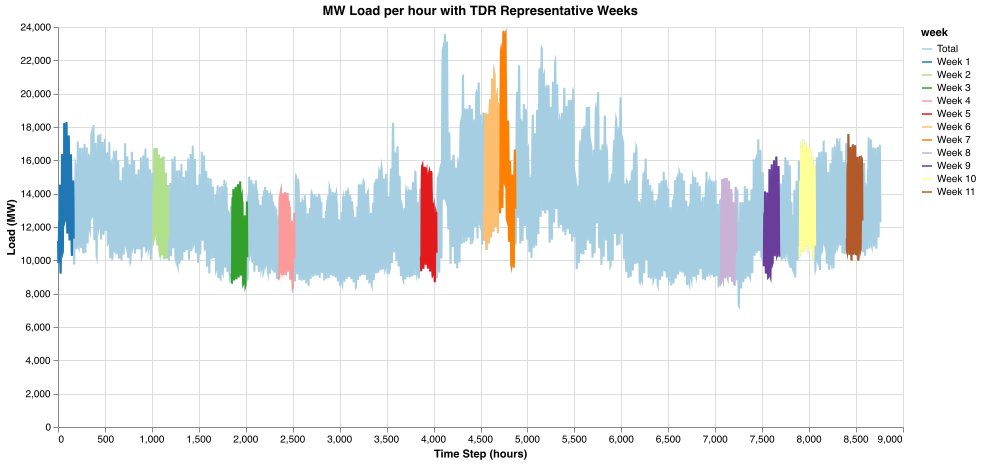

In [254]:
loads_with_TDR  |>
@vlplot( 
    x={:hour,title="Time Step (hours)",labels="week:n"}, y={:MW,title="Load (MW)"}, 
    color={"week:n", scale={scheme="paired"},sort="decsending"}, title="MW Load per hour with TDR Representative Weeks",
    width=845,height=400,mark={
        :line
    })

In [ ]:
## For F: Is there a way to compare results to see similarities?